In [222]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from math import ceil

from sklearn.metrics import mean_absolute_error

In [139]:
data = pd.read_csv('./Electric_Production.csv')

X_hist, X_obs = np.split(data, [250])

In [323]:
data

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


I chose a time series dataset for electricity production by month for the years 1985 to 2018. I split the dataset into 'historical' and 'observed' sets so that I may forecast on the observed data.

Text(0, 0.5, 'Electricity Production')

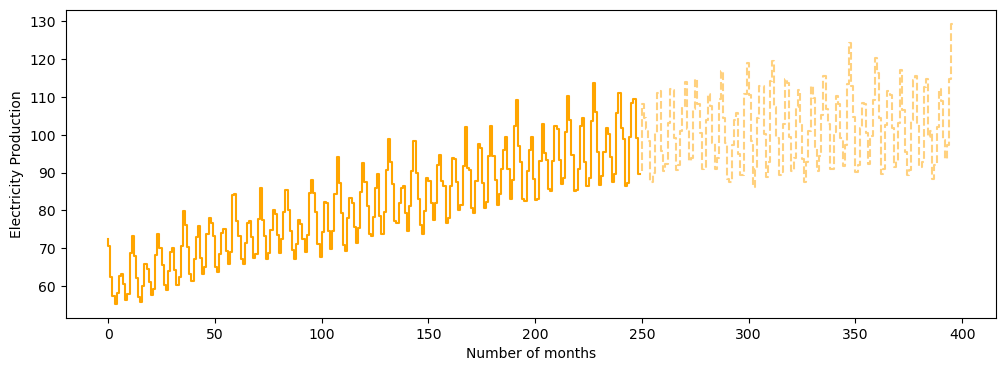

In [140]:
fig, ax = plt.subplots(figsize = (12,4))

ax.step(X_hist.index, X_hist['IPG2211A2N'], color = 'orange', alpha=1)
ax.step(X_obs.index, X_obs['IPG2211A2N'], color = 'orange', alpha=0.5, linestyle='--')

ax.set_xlabel('Number of months')
ax.set_ylabel('Electricity Production')

In [141]:
sd = seasonal_decompose(
    x = X_hist['IPG2211A2N'],
    model = 'multiplicative',
    period = 12
)

In [142]:
lr = LinearRegression(fit_intercept = True)
lr.fit(np.arange(238).reshape(-1,1), sd.trend.dropna().values.reshape(-1,1))
print('y = %.2fx + %.2f'%(lr.coef_[0], lr.intercept_[0]))

y = 0.15x + 63.18


I discovered that the I decomposed the time series into a trendline and seasonality components and computed the ACF to determine whether the remaining residual was stationary.

Text(0.5, 1.0, 'Seasonality')

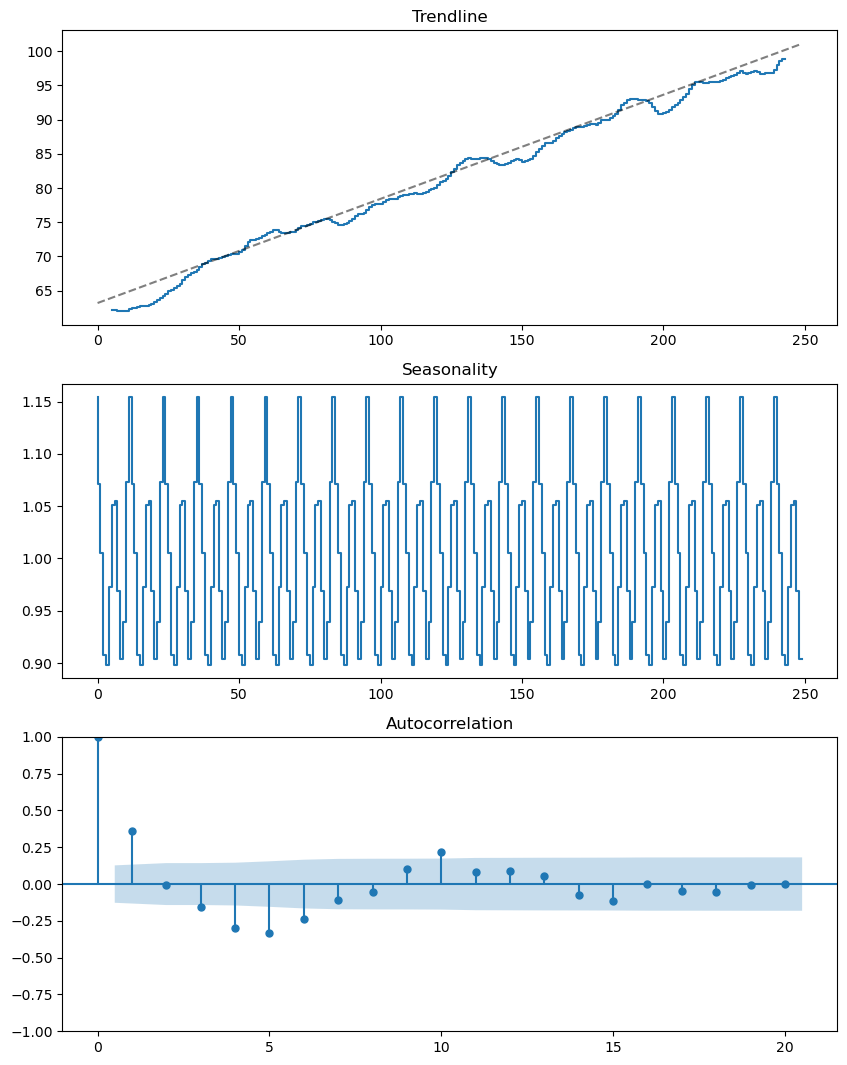

In [143]:
fig, ax = plt.subplots(3,1, figsize=(10,13))

ax[0].step(X_hist.index, sd.trend)
ax[0].plot(X_hist.index, lr.coef_[0]*X_hist.index + lr.intercept_[0], '--', color='black', alpha = 0.5)
ax[1].step(X_hist.index, sd.seasonal)
plot_acf(sd.resid.dropna(), lags = 20, ax = ax[2])

#ax[0].set_xlabel('Number of months')
#ax[1].set_xlabel('Number of months')
#ax[0].set_ylabel('Trendline')
#ax[1].set_ylabel('Seasonality')
ax[0].set_title('Trendline')
ax[1].set_title('Seasonality')


In [144]:
seasonality = sd.seasonal[:12]
trend = lambda x: lr.coef_[0]*x + lr.intercept_[0]


# Extrapolating
f_trend = trend(X_obs.index)

f_seasonality = np.array([])

for x in range(ceil(X_obs.shape[0]/12)):
    f_seasonality = np.append(f_seasonality, seasonality)

f_seasonality = f_seasonality[:X_obs.shape[0]]

I then extrapolated the decomposition to forecast in the prediction window.

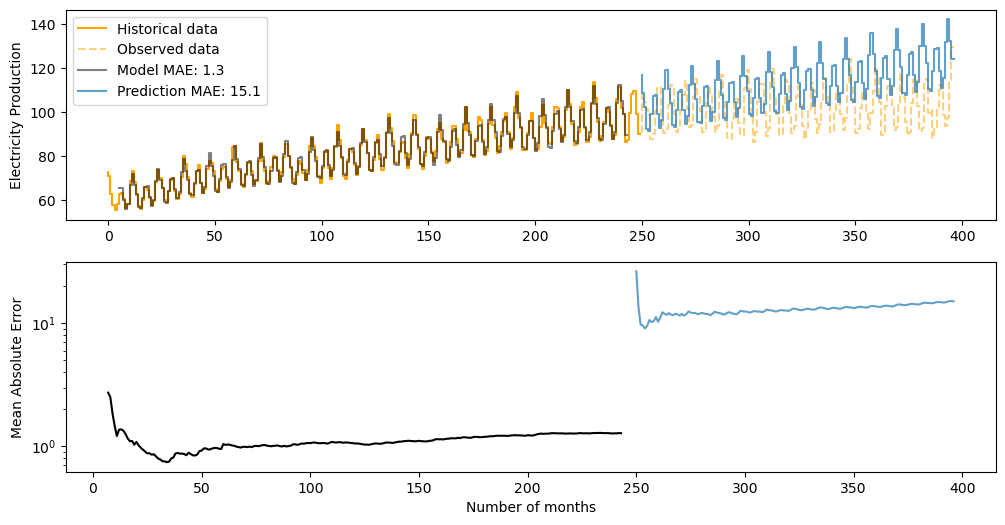

In [216]:
fig, (ax,ax_e) = plt.subplots(2, 1, figsize = (12,6))

ax.step(X_hist.index, X_hist['IPG2211A2N'], color = 'orange', alpha=1, label = 'Historical data')
ax.step(X_obs.index, X_obs['IPG2211A2N'], color = 'orange', alpha=0.5, linestyle='--', label = 'Observed data')

model_e = mean_absolute_error(sd.seasonal[6:244] * sd.trend.dropna(), sd.observed[6:244])
pred_e = mean_absolute_error(f_seasonality * f_trend, X_obs['IPG2211A2N'])

ax.step(X_hist.index, sd.seasonal.dropna() * sd.trend.dropna(), alpha = 0.5, color = 'black', label='Model MAE: %.1f'%model_e )
ax.step(X_obs.index, f_seasonality * f_trend, '-',alpha = 0.7, label = 'Prediction MAE: %.1f'%pred_e)

ax_e.set_xlabel('Number of months')
ax.set_ylabel('Electricity Production')

ax.legend()



error_mod = [mean_absolute_error(sd.seasonal[6:i] * sd.trend.dropna()[0:i-6], sd.observed[6:i]) for i in range(7, 244)]

ax_e.plot(data.index[7:244], error_mod, color = 'black')

error_pred = [mean_absolute_error(f_seasonality[:i+1] * f_trend[:i+1], X_obs['IPG2211A2N'][:i+1]) for i in range(X_obs.shape[0])]

ax_e.plot(data.index[250:], error_pred, '-',alpha = 0.7)

ax_e.set_ylabel('Mean Absolute Error')
ax_e.set_yscale('log')

As is immediately evident, the linear fit did not appropriately capture the trendline. This is likely because the trend became logarithmic as the market became saturated. The seasonality does, however, seem appropriate. I included the MAE calculated over time to demonstrate the tendency for the forecast to become increasingly 'incorrect' (after reaching equilibrium).

Additionally, the ACF suggests there is still some structure within the decomposition. In particular, electricity demand goes on a yearly cycle (period = 12mo.) however there is some existing structure on a 6-mo. period due to the difference in demand over the seasons. I explore this remaining structure in the residue in the subsequent try-it.

### Second part of Assignment:

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


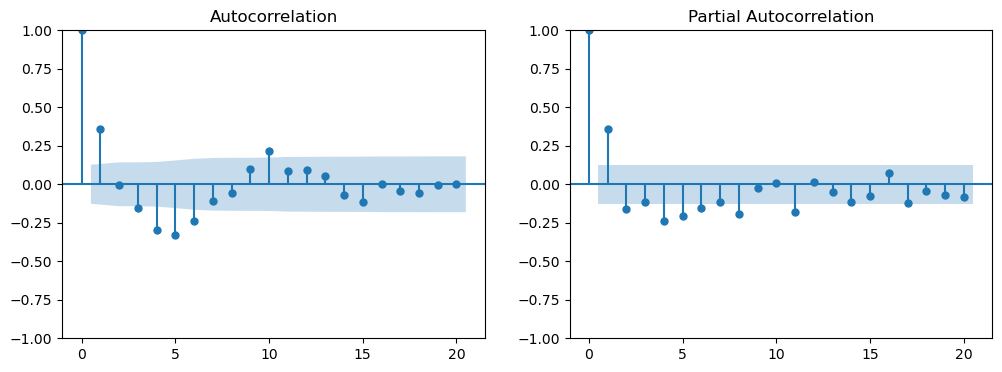

In [312]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

_ = plot_pacf(sd.resid.dropna(), lags=20, ax=ax[1])
_ = plot_acf(sd.resid.dropna(), lags=20, ax=ax[0])

In [273]:
arma = ARIMA(sd.resid.dropna(), order=(1,0,1))
result_hist = arma.fit()


sd_full = seasonal_decompose(
    x = data['IPG2211A2N'],
    model = 'multiplicative',
    period = 12
)
arma = ARIMA(sd_full.resid.dropna(), order=(1,0,1))
result_pred = arma.fit()

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packag

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


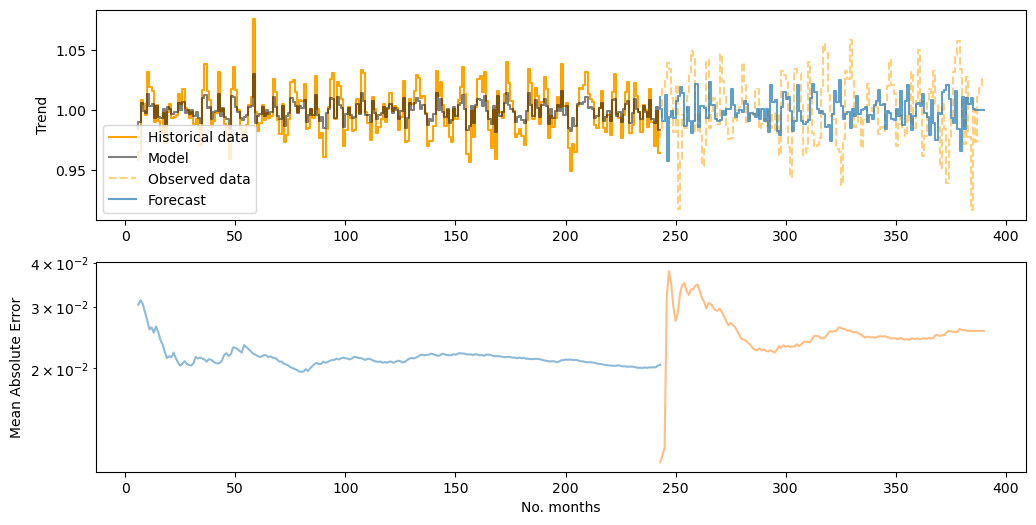

In [322]:
fig, (ax, ax_e) = plt.subplots(2, 1, figsize=(12,6))

index_hist = sd.resid.dropna()
index_f = sd_full.resid.dropna()
ax.step(index_hist.index, sd.resid.dropna(), color='orange', label='Historical data')
ax.step(index_hist.index, result_hist.predict(start=1,end=index_hist.shape[0]), color='black', alpha=.5, label = 'Model')
ax.step(range(index_hist.index[-1], index_f.index[-1]+1), sd_full.resid[index_hist.index[-1]:].dropna(), linestyle='--', alpha=.5, color='orange', label = 'Observed data')
ax.step(range(index_hist.index[-1], index_f.index[-1]+1), result_pred.predict(start=index_hist.index[-1],end=index_f.index[-1]), alpha=.7, label='Forecast')

ax.set_ylabel('Trend')
ax_e.set_xlabel('No. months')
ax_e.set_ylabel('Mean Absolute Error')

ax.legend()

total_trend = sd_full.resid.dropna()
total_pred = result_pred.predict(start = total_trend.index[0], end = total_trend.index[-1])

error_trend = [mean_absolute_error(total_trend[:i], total_pred[:i]) for i in range(index_hist.index[0], index_hist.index[-1]+1)]

error_pred = [
    mean_absolute_error(total_trend[index_hist.index[-1]:i+1], total_pred[index_hist.index[-1]:i+1]) for i in range(index_hist.index[-1], total_trend.index[-1]+1)]

#ax_e.axvline(index_hist.index[-1], linestyle='--',color='black', alpha=0.5)

ax_e.plot(index_hist.index, error_trend, alpha=0.5)
ax_e.plot(range(index_hist.index[-1], index_f.index[-1]+1), error_pred, alpha=0.5)

ax_e.set_yscale('log')